In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


Primeras filas del dataset:
   type                                               body
0  SPAM  alertamos sobre estafa con pagos en codigo cif...
1  SPAM                cod de acceso de microsoft <NUMBER>
2  SPAM  tu bono de <NUMBER> mb ha expirado o consumist...
3  SPAM  sin saldo llama al <NUMBER> y sigue comunicand...
4  SPAM  adelantamos la navidad en claro usa s <NUMBER>...

Clases en 'type':
type
SPAM    6463
HAM     6059
Name: count, dtype: int64


C:\Users\ALEX\AppData\Local\Temp\ipykernel_15764\4061198887.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="type", palette="Set2")


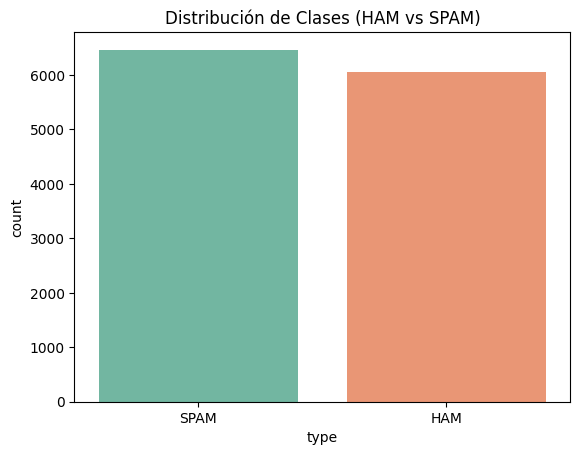

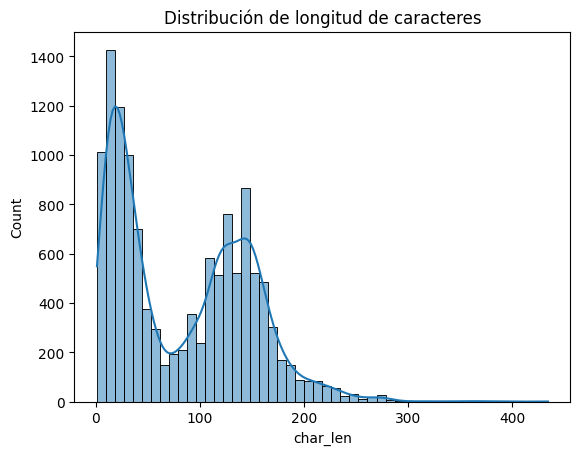

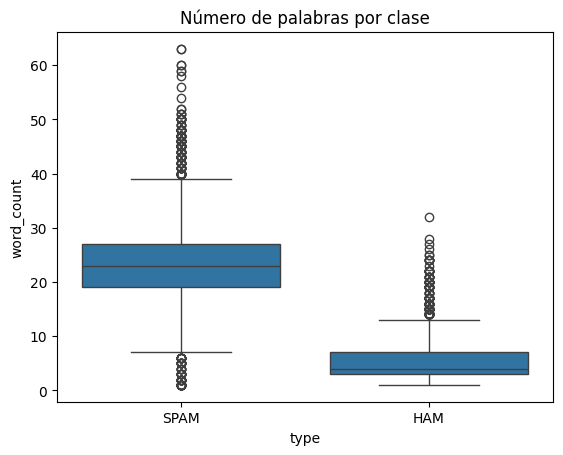

In [7]:
# Cargar dataset
df = pd.read_csv("DATA.csv", encoding="latin-1")  # cambia al nombre de tu archivo

print("Primeras filas del dataset:")
print(df.head())

print("\nClases en 'type':")
print(df['type'].value_counts())

# Distribución de clases
sns.countplot(data=df, x="type", palette="Set2")
plt.title("Distribución de Clases (HAM vs SPAM)")
plt.show()

# Longitud de los mensajes
df['char_len'] = df['body'].astype(str).apply(len)
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))

sns.histplot(df['char_len'], bins=50, kde=True)
plt.title("Distribución de longitud de caracteres")
plt.show()

sns.boxplot(data=df, x="type", y="word_count")
plt.title("Número de palabras por clase")
plt.show()


In [23]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Función de limpieza
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # minúsculas
    text = re.sub(r'\d+', ' ', text)  # eliminar números
    text = re.sub(r'\W+', ' ', text)  # eliminar símbolos
    text = re.sub(r'\s+', ' ', text)  # eliminar espacios extras
    return text.strip()

df['body'] = df['body'].apply(clean_text)


In [24]:
# Vectorización TF-IDF con límite de vocabulario
vectorizer = TfidfVectorizer(
    max_features=5000,   # máximo vocabulario
    min_df=5,            # palabra debe aparecer al menos en 5 documentos
    max_df=0.8,          # ignorar palabras que aparecen en más del 80% de documentos
    ngram_range=(1,2)    # usar unigrama y bigrama para captar frases cortas
)

X_train_vec = vectorizer.fit_transform(X_train_texts)
X_test_vec = vectorizer.transform(X_test_texts)

print("Shape train:", X_train_vec.shape)
print("Shape test:", X_test_vec.shape)


Shape train: (10012, 5000)
Shape test: (2504, 5000)


In [9]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [10]:
class SpamClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SpamClassifier(input_dim=X_train_vec.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.0090
Epoch 2/20, Loss: 0.0078
Epoch 3/20, Loss: 0.0071
Epoch 4/20, Loss: 0.0067
Epoch 5/20, Loss: 0.0062
Epoch 6/20, Loss: 0.0059
Epoch 7/20, Loss: 0.0060
Epoch 8/20, Loss: 0.0055
Epoch 9/20, Loss: 0.0053
Epoch 10/20, Loss: 0.0053
Epoch 11/20, Loss: 0.0050
Epoch 12/20, Loss: 0.0050
Epoch 13/20, Loss: 0.0050
Epoch 14/20, Loss: 0.0051
Epoch 15/20, Loss: 0.0050
Epoch 16/20, Loss: 0.0049
Epoch 17/20, Loss: 0.0050
Epoch 18/20, Loss: 0.0047
Epoch 19/20, Loss: 0.0049
Epoch 20/20, Loss: 0.0046


Reporte de clasificación:

              precision    recall  f1-score   support

         HAM       0.99      1.00      0.99      1212
        SPAM       1.00      0.99      0.99      1292

    accuracy                           0.99      2504
   macro avg       0.99      0.99      0.99      2504
weighted avg       0.99      0.99      0.99      2504



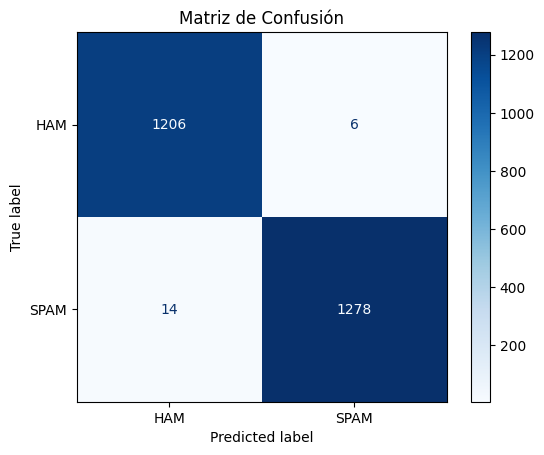

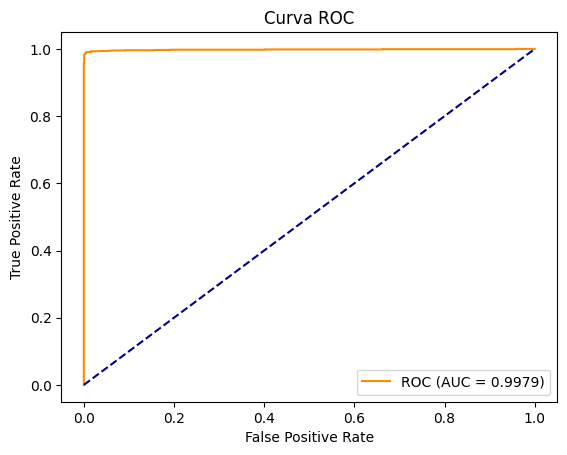

In [22]:
model.eval()
y_true, y_pred, y_proba = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)

        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_proba.extend(probs.cpu().tolist())

# Reporte
print("Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=["HAM", "SPAM"]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HAM", "SPAM"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0,1],[0,1],"--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()


In [20]:
def predecir_mensaje(model, vectorizer, mensaje, device):
    model.eval()
    vec = vectorizer.transform([mensaje])
    tensor = torch.tensor(vec.toarray(), dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(tensor)
        _, predicted = torch.max(output, 1)
    return "SPAM" if predicted.item() == 1 else "HAM"

ejemplo1 = "Feliz cumpleaños tio"
ejemplo2 = "a que hora vas a venir"

print("Ejemplo 1:", predecir_mensaje(model, vectorizer, ejemplo1, device))
print("Ejemplo 2:", predecir_mensaje(model, vectorizer, ejemplo2, device))


Ejemplo 1: HAM
Ejemplo 2: HAM
